In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from util.experiment import Experiment, load_experiments
from util.plotting import plot_label_clusters
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.manifold import TSNE

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (valid_images, valid_labels) = fashion_mnist.load_data()
valid_images = valid_images.astype("float32") / 255.0
valid_images = tf.expand_dims(valid_images, axis=-1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

2022-05-26 11:14:03.669291: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
experiments = load_experiments(with_params={"beta": 2})
experiments.keys()

dict_keys(['26-05-2022_0018_stay-traditional-american-number', '26-05-2022_0001_love-important-late-family', '25-05-2022_2352_continue-see-clear-money', '26-05-2022_0009_say-environmental-low-month', '25-05-2022_2344_mean-democratic-morning-way'])

In [25]:
experiment = experiments['26-05-2022_0018_stay-traditional-american-number']['experiment']
#model = experiment.load_model()

## Reconstruction Comparison

<Figure size 1080x720 with 0 Axes>

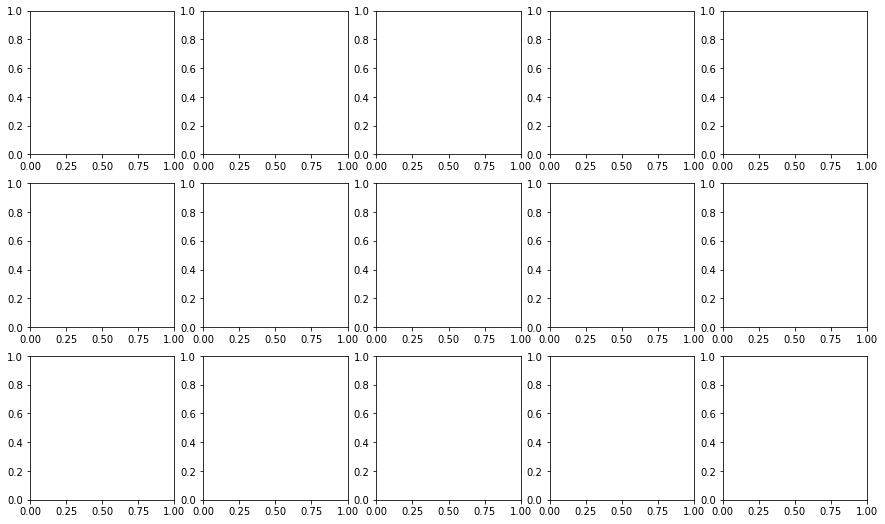

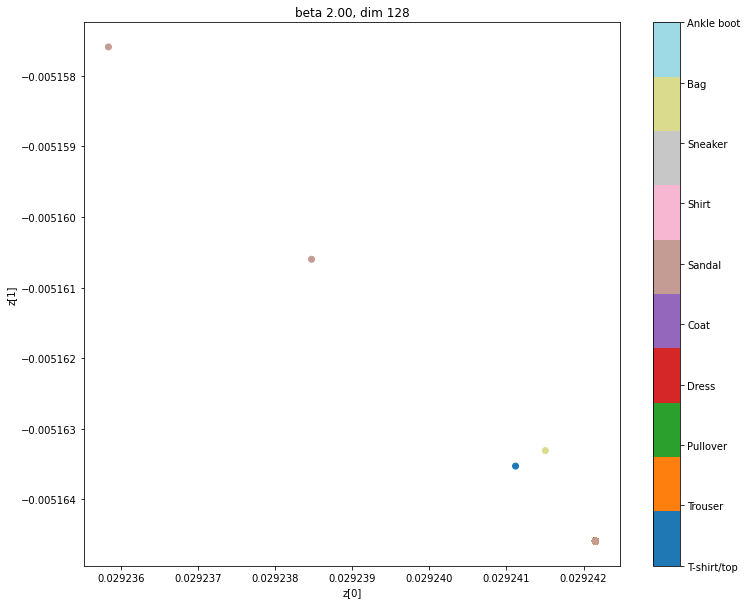

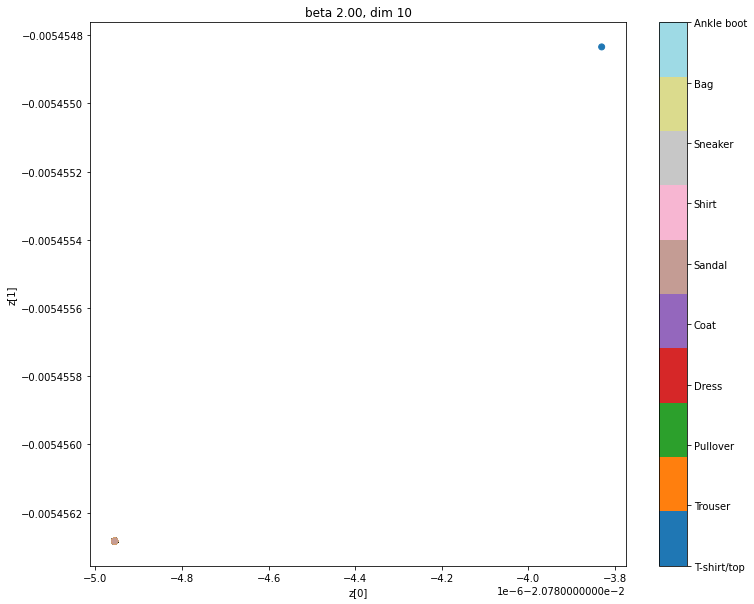

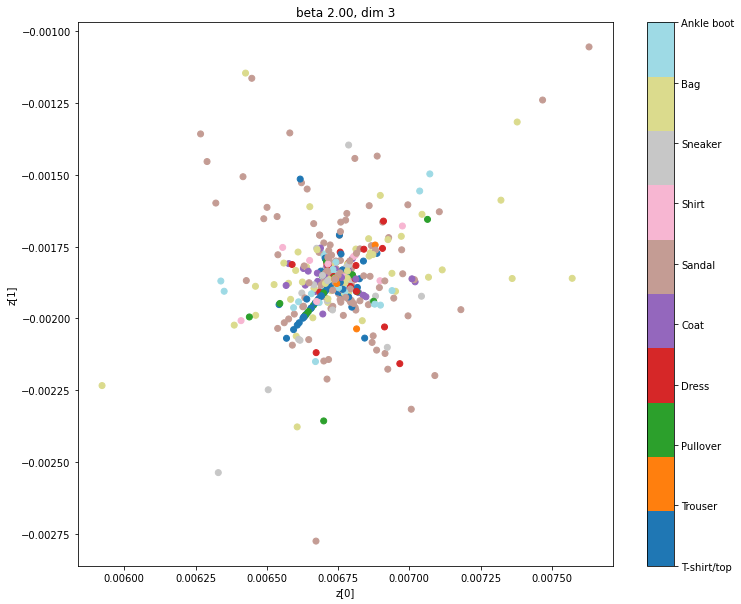

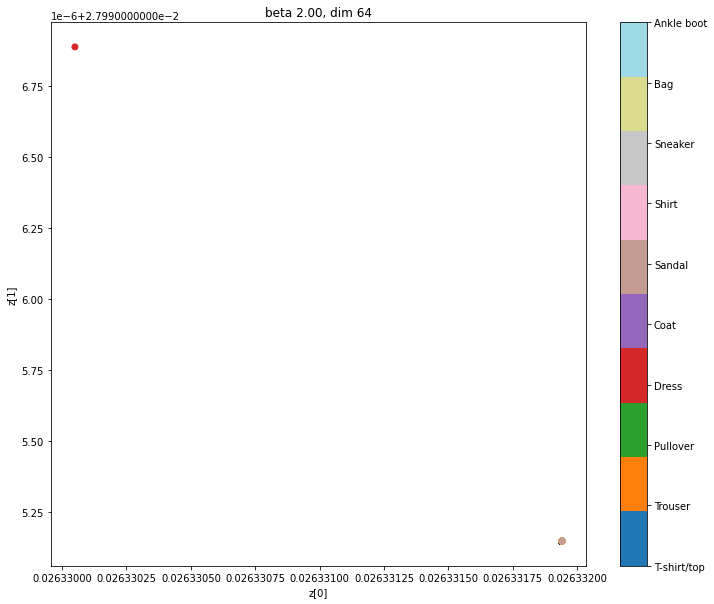

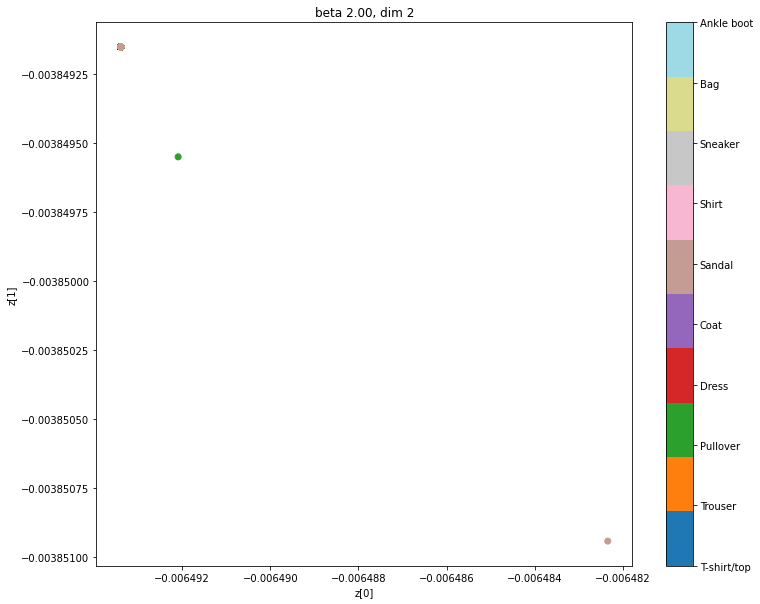

In [5]:
num_experiments = len(experiments.keys())
zm = 3
fig = plt.figure(figsize=(15, 10))
fig, axs = plt.subplots(ncols=num_experiments, nrows=3, figsize=(zm * num_experiments, zm * 3))

example_data = valid_images[100]
example_data = tf.expand_dims(example_data, axis=0)  # add batch dim

for i, key in enumerate(experiments.keys()):
    # Load data
    experiment = experiments[key]['experiment']
    model = experiment.load_model()
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])
    
    plot_label_clusters(model, valid_images, valid_labels, experiment.vis_dir, title=title, show=True)
    
    z_mean, z_log_var = model.encoder(example_data)
    reconstruction = model.decoder(z_mean)   
    stddev = tf.math.sqrt(tf.math.square(z_mean) * (tf.math.exp(z_log_var)-1))
    sampled = model.decoder(tf.random.normal(mean=z_mean, stddev=stddev, shape=(1, experiment.params['latent_dim'])))
    
    # Plot x, x_rec and sample from z
    for axi, (data, label) in enumerate(
        zip(
            [example_data, reconstruction, sampled],
            ["data", "reconstruction", "sample"],
        )
    ):
            axs[axi, i].matshow(
                data.numpy().squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, i].axes.get_xaxis().set_ticks([])
            axs[axi, i].axes.get_yaxis().set_ticks([])
            axs[axi, 0].set_ylabel(label)
            axs[0, i].set_title(title)

History tf.Tensor(244.34157, shape=(), dtype=float32)


/Users/christoph/Documents/Studium/Universität Wien/Informatik/SoSe22/P2/code/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/christoph/Documents/Studium/Universität Wien/Informatik/SoSe22/P2/code/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

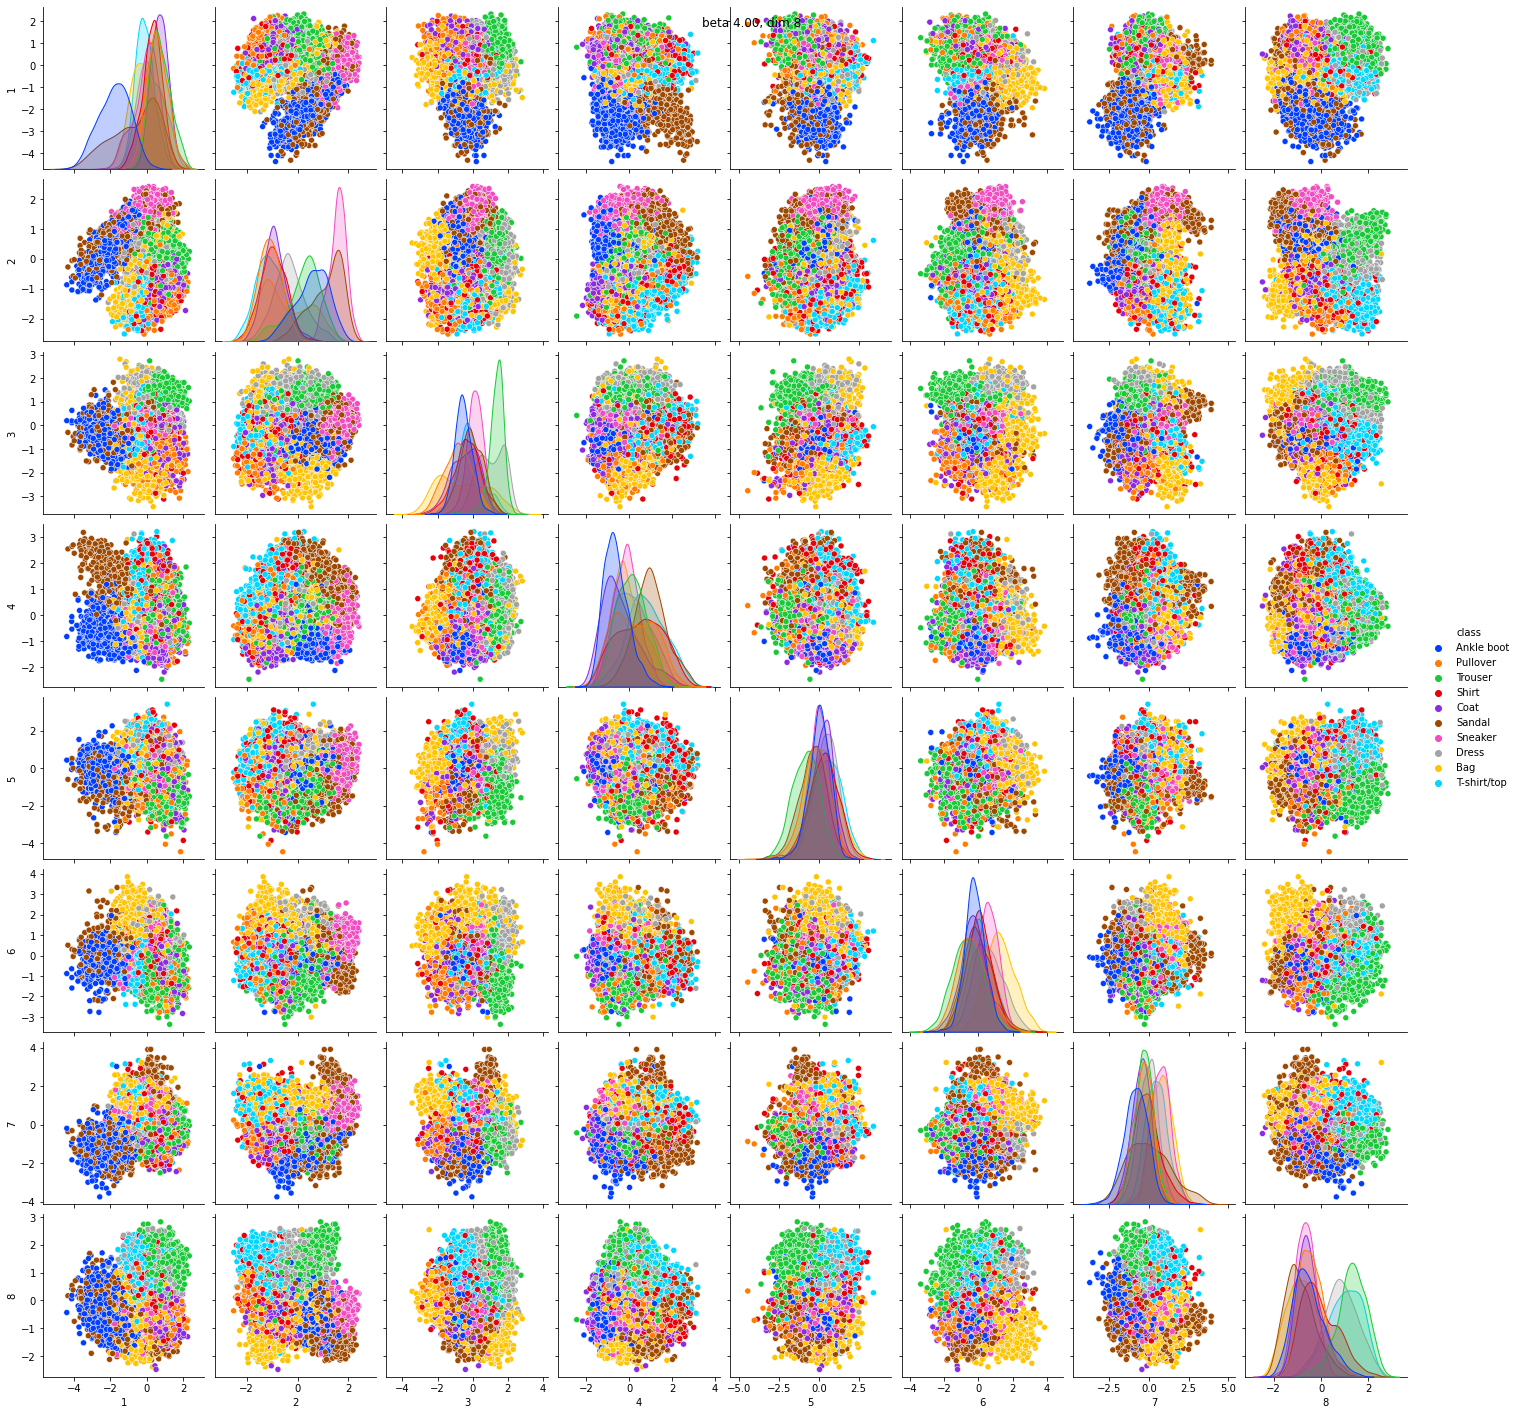

In [8]:
for key in experiments.keys():
    # key = '09-05-2022_2016_feel-major-eye-guy'
    experiment = experiments[key]['experiment']
    print("History", min(experiment.history['train_loss']))
    model = experiment.load_model()
    title = "beta %.2f, dim %d" % (experiment.params['beta'], experiment.params['latent_dim'])

    #plot_label_clusters(model, train_images, train_labels, experiment.vis_dir, title=title, show=True)
    


    # Pairplot of dimensions
    _, _, z = model.encoder(valid_images)
    train_labels_decoded = [class_names[i] for i in valid_labels]
    labels_df = pd.DataFrame(train_labels_decoded, columns = ['class'])
    z_df = pd.DataFrame(z, columns = [str(i) for i in range(1, z.shape[1] + 1)])

    labeled_z_df = pd.concat([labels_df, z_df], axis=1)
    pp = sb.pairplot(labeled_z_df, hue="class", palette=sb.color_palette("bright", 10))
    pp.fig.suptitle(title)
    
    # TSNE
    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(z_df)
    tsne_result.shape
    
    # Plot the result of our TSNE with the label color coded
    # A lot of the stuff here is about making the plot look pretty and not TSNE
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels_df})
    fig, ax = plt.subplots(1)
    sb.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=40, alpha=0.6)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

(28, 28, 1)

TensorShape([10000, 1, 1, 28, 28, 1, 1, 1, 1])